# Walk through some of the main results

This notebook shows how some of the main figures can be easily replicated.

At the moment, you can only download and analyze:
* All of the epochs of our first subject (gradiometers only, decimated time),
* The univariate effect size for each analysis averaged across all subjects,
* The decoding scores for each subject and each analysis (decimated time),

The raw and epoched data will be made publicly available once the manuscript
is accepted for publication.

/!\ On the server, there's only one core, so be patient!

"`In [*]:`" indicates that the script is still running.

In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np

from mne import read_epochs
from mne.decoding import TimeDecoding, GeneralizationAcrossTime

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVR

from jr.gat import subscore
from jr.gat import AngularRegression, scorer_angle
from jr.stats import corr_linear_circular
from jr.plot import pretty_gat, pretty_decod


# Within subject univariate analysis: present - absent

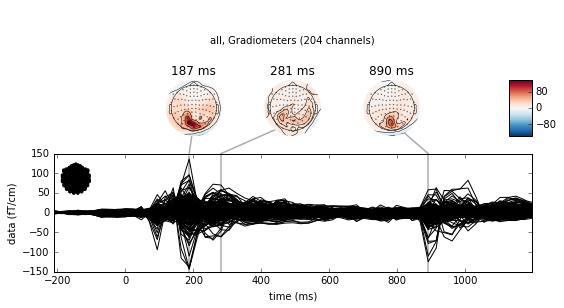

In [2]:
# Load first subject epochs (~41 Mo)
epochs = read_epochs('../data/subject_01-epo.fif', verbose=False)
with open('../data/subject_01-eve.pkl', 'rb') as f:
    events = pickle.load(f)

# Let's have a look at the average response across trials
evoked = epochs.average()
evoked.plot_joint(title='all')
plt.show()

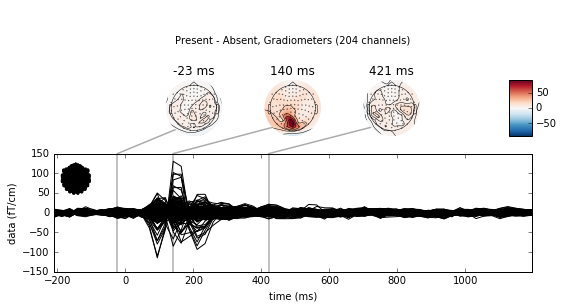

In [3]:
# Let's see whether we can isolate the target evoke response.
# For this we can subtract the absent trials (mask only) from the present:
present = events['target_present']
evo_present = epochs[present].average()
evo_absent = epochs[-present].average()

evoked.data = evo_present.data - evo_absent.data
evoked.plot_joint(title='Present - Absent')
plt.show()

# Within subject decoding: present - absent
The presence of the target evoke some activity. We can 'decode' the
target presence at each time point by fitting a classifier with all
sensors at a given time point.

See `method_decoding.ipynb` to see how this is built.

/!\ On the server, there's only one core, so be patient!

[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:   14.7s remaining:    4.9s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   15.4s remaining:   46.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:   15.4s remaining:  1.8min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:   15.5s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.5s finished
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


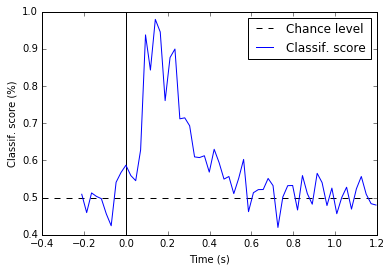

In [4]:
# Since there's a large class imbalance, we use a probabilistic output
# and an ROC scorer.
def scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred[:, 1])
td = TimeDecoding(predict_method='predict_proba', scorer=scorer, n_jobs=-1)
td.fit(epochs, y=events['target_present'])
td.score(epochs, y=events['target_present'])
td.plot(chance=.5)
plt.show()

[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:   14.4s remaining:    4.8s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   14.6s remaining:   43.7s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:   14.7s remaining:  1.7min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:   14.8s remaining:   14.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.8s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    3.2s remaining:   22.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.3s remaining:   12.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    6.7s remaining:    6.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    7.3s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s

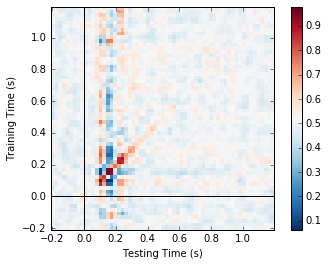

In [5]:
# The decoding tells very little about the underlying neural substrates.
# Temporal generalization can help clarify the functional architecture that
# underlies the signal.

# /!\ On the server, there's only one core, so be patient!

gat = GeneralizationAcrossTime(predict_method='predict_proba', scorer=scorer,
                               n_jobs=-1)
y = events['target_present']  # in machine learning, y is the regressor.

# Fit models with cross validation.
gat.fit(epochs, y=y)

# Predict orientation and score the difference between true and predicted
# presence of the stimulus.
gat.score(epochs, y=y)

# Plot the scores
gat.plot()
plt.show()

[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


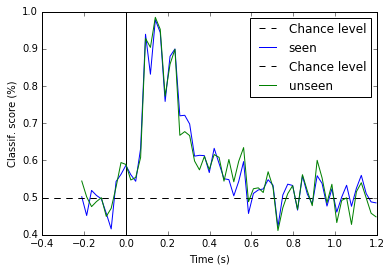

In [6]:
# These scores reflects both seen and unseen trials. Let's see how these
# two categories differ with one another.
# For clarity purposes, we'll compute the ROC versus all absent trials in
# each conditions.
seen = events['detect_button'] > 0
absent = -events['target_present']  
subselects = dict(seen=np.where(seen | absent)[0],
                  unseen=np.where(-seen | absent)[0],)
y = events['target_present']

fig, ax = plt.subplots(1)
for name, idx in subselects.iteritems():
    # Do not refit, just score the seen and unseen separately
    scores = gat.scores_ = subscore(gat, y=y[idx], sel=idx)
    # Plot each condition
    gat.plot_diagonal(chance=.5, ax=ax, label=name, show=False)
plt.show()

As you can see, with this subject, we can decode the presence of the target
even when it's reported as unseen. This is a classic result, but it's still
nice to reproduce.


# Within subject univariate analysis: orientation
Detecting the presence of the target is easy. Let's try to detect the
orientation of the probe angle

Univariate analyses: do the amplitude of the meg channels correlate with the
angle of the stimulus. Note that for practical purposes, we consider that the
angle is two times the orientations (so that we can easily use trigonometry).

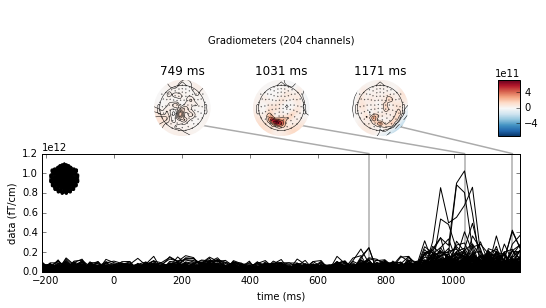

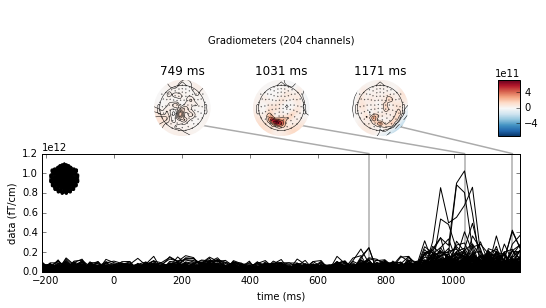

In [7]:
# define the regressor: here the probe angle
y = np.array(events['probe_circAngle'].values)
X = epochs._data

# We need a 2D X (trials x dimension)
n_trial, n_chan, n_time = epochs._data.shape
X = X.reshape([-1, n_chan * n_time])

# linear circular correlation between MEG and stim angle
_, R2, _ = corr_linear_circular(X, y)

# plot the effect size using MNE
R2 = R2.reshape([n_chan, n_time])
evoked.data = R2
evoked.plot_joint()

# Within subject decoding: orientation
The same can be done with decoding. One of the advantages is that we
are not restricted to R squared estimates (which are only one-tailed), but we
can estimate the angle error between the true and the predicted angle (which
is two-tailed). This will simplify the stats across subjects, because we know
the chance level can be analytically inferred.

[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   19.0s remaining:   57.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:   20.1s remaining:    6.7s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:   20.4s remaining:   20.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:   20.7s remaining:  2.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   20.7s finished
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


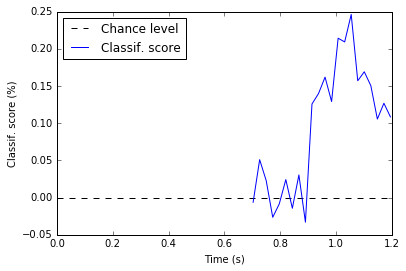

In [8]:
# Let's use a double regressor to estimate the angle from the sine and cosine
# See `method_model_types.ipynb` to see understand how this is built.

#/!\ On the server, there's only one core, so be patient!

clf_angle = make_pipeline(StandardScaler(), AngularRegression(clf=LinearSVR()))
td = TimeDecoding(clf=clf_angle, scorer=scorer_angle, n_jobs=-1)

# Define regressor
y = np.array(events['probe_circAngle'].values)

# This can take a while, so let's only decode around probe onset
epochs_probe = epochs.crop(.700, copy=True)

# Fit models with cross validation
td.fit(epochs_probe, y=y)

# Predict orientation and score the difference between true and predicted
# orientations
td.score(epochs_probe, y=y)

# Plot the scores
td.plot(chance=0.)
plt.show()

The decoding of the probe orientation is relatively easy. However, for this
subject, the decoding of the target orientation may be more difficult (try it!).

In the manuscript, we only used default MNE and Scikit-Learn parameters, to avoid 
overfitting and convince our readers that the reported effects are not p-hacked.
You may however use bagging or other optimization strategies to increase decoding
power in each subject.


# Average ERFs across subjects for each analysis

In [9]:
# Load average ERF effects (~14 Mo)
with open('../data/results_evoked.pkl', 'rb') as f:
    erf_analyses = pickle.load(f)

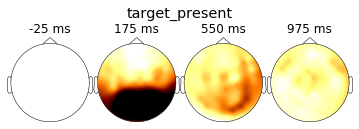

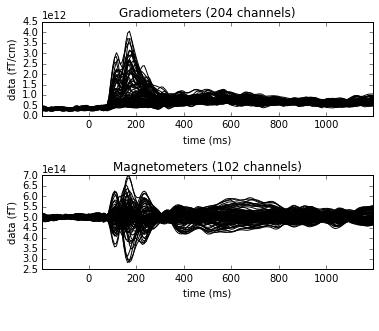

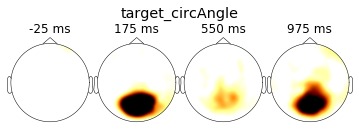

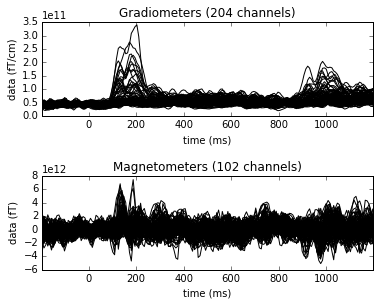

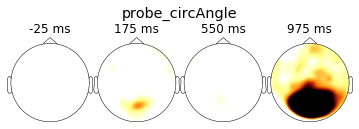

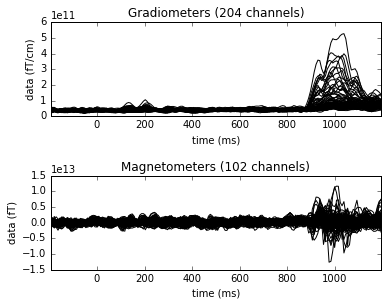

In [10]:
# Here, we will only plot a subselection only to avoid crowding.
# But you can play with the data!
erf_analyses = [a for a in erf_analyses if a['name'] in [
                'target_present', 'target_circAngle', 'probe_circAngle']]

# Define time regions of interest for which you want a topography
tois = [(-.100, 0.050), (.100, .250), (.300, .800), (.900, 1.050)]

# Plot mean effect size within each toi.
for analysis in erf_analyses:
    name, evoked = analysis['name'], analysis['evoked']
 
    # Note that the grads have already been combined.
    # Adjust color scale from 10th and 90th percentile of combined grads
    vmin, vmax = np.percentile(evoked.data[::3, :], [10, 90])

    # Plot topo of mean effect on TOI
    fig, axes = plt.subplots(1, len(tois), figsize=[6, 2])
    fig.subplots_adjust(wspace=0.01, left=0.)
    for ax, toi in zip(axes, tois):
        evoked.plot_topomap(times=[np.mean(toi)], average=np.ptp(toi),
                            cmap='afmhot_r', ch_type='grad', show=False,
                            contours=False, scale=1, colorbar=False,
                            sensors=False, axes=ax, vmin=vmin, vmax=vmax,
                            title=name)
    # Plot butterfly
    evoked.plot()

These topograhies already show that multiples codes (orientation, presence, 
contrasts etc) are contained in the MEG signals. Decoding analyses will 
help use refine this observation.


# Decoding scores for each subject and each analysis

In [11]:
# Load data  (~31 Mo)
with open('../data/results_decoding.pkl', 'rb') as f:
    gat_analyses = pickle.load(f)

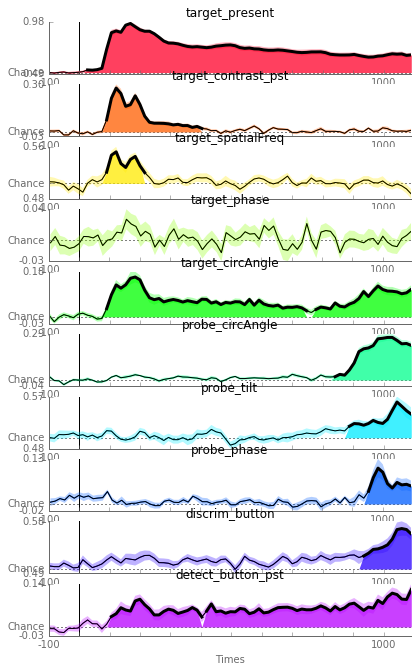

In [12]:
fig, axes = plt.subplots(len(gat_analyses), 1, figsize=[6.5, 11])
for (analysis, ax) in zip(gat_analyses, axes):
    chance = analysis['chance']
    times = analysis['times']
    color = analysis['color']
    
    # Get diagonal scores for each subject to get SEM
    scores_diag = np.array([np.diag(score) for score in analysis['scores']])

    # p values cluster corrected for diagonal results
    pval_diag = analysis['pval_diag']

    # Plot
    pretty_decod(scores_diag, times=times, sig=pval_diag < 0.01,
                 chance=chance, color=color, fill=True, ax=ax)
    ax.set_title(analysis['name'])


Here, it becomes clear that all sensory and decisional features can be
decoded. Importantly, it appears that only the features relevant to the task
(presence, orientations, and visibility) can be decoded during the 
delay period.

# GAT across subject: Presence vs Absent

For each of the above decoding analyses, you can plot the average GAT too.

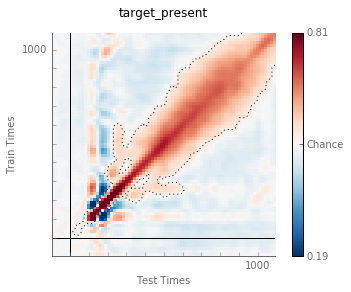

In [13]:
analysis = gat_analyses[0]  # try changing the analysis yourself to inspect the results
chance = analysis['chance']
times = analysis['times']
# mean across subjects
scores = np.mean(analysis['scores'], axis=0)
# p values cluster corrected for whole GAT matrix
pval = analysis['pval']
# plot
fig, ax = plt.subplots(1)
pretty_gat(scores, times=times, sig=pval < 0.01, ax=ax, chance=chance)
ax.set_title(analysis['name'])
plt.show()